## Segmentation Cleanup V3
This notebook was created for users looking to clean up and ehance the outputs from DeepCell/Notebook1.\
\
This notebook contains the following:
1. Data visualization. This is intended to make it easier to set filters for your data to select certain cells.
2. Cell expansion. To be used in cases where only the nucleus of cells are being captured even with membrane markers. Options include by set pixel radius or percent per cell.
3. Split large nuclei. From the segmentation utils function to split cells where nuclei are merged.
4. Cell removal. Removal of artifact left over from segmentation such as mixed signal or cells with extremely low size.
5. Creat new cell table.

xxxxxxx_Work in progress_xxxxxxx \
- One thing that i really need to add in here is an option to link and use the nuclear mask.\
- At the end of the day what even is the nuclear mask? It's honestly never used unless you want it for a hyper specific reason.


In [3]:
#import packages
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import skimage.io as io
import math

from alpineer import io_utils
from ark.utils import plot_utils
from scipy.ndimage import grey_dilation

from ark.segmentation import marker_quantification, segmentation_utils
from ark.utils import deepcell_service_utils, example_dataset, plot_utils 

### Set paths
The path structure should pull from the segmentation mask you wish to edit. Once edited, this new segmentation mask and cell table should be saved to a new output folder, afterwards it can be edited with cell removal.

In [2]:
#setworking directory
os.getcwd()

'/krummellab/data1/zachsten/personal/MIBI_data_files/zach_test_sets/Scripts'

In [3]:
os.chdir('/krummellab/data1/zachsten')
os.getcwd()

'/krummellab/data1/zachsten'

In [5]:
#set base directory
base_dir = 'personal/MIBI_data_files/zach_test_sets/'

#set paths for raw segmentation output
tiff_dir = os.path.join(base_dir, "age_data_subset_organized/")
deepcell_input_dir = os.path.join(base_dir, "segmentation_v1/deepcell_input")
deepcell_output_dir = os.path.join(base_dir, "segmentation_v1/deepcell_output")
cell_table = os.path.join(base_dir, "segmentation_v1/cell_table_expanded/cell_table_arcsinh_transformed_expanded.csv")
df = pd.read_csv(cell_table)

#set paths for new expanded output
#expansion_deepcell_output_dir = os.path.join(base_dir, "segmentation_v1/deepcell_output_expanded")
#expansion_cell_table_dir = os.path.join(base_dir, "segmentation_v1/cell_table_expanded/")
#expansion_deepcell_visualization_dir =os.path.join(base_dir, "segmentation_v1/deepcell_output_viz")

#idk if something needs to be done for the split nuclei... we'll see later.

#set paths for final cell removal output
clean_deepcell_output_dir = os.path.join(base_dir, "segmentation_v1/deepcell_output_cell_rem")
clean_cell_table_dir = os.path.join(base_dir, "segmentation_v1/cell_table_cell_rem/")
clean_deepcell_visualization_dir =os.path.join(base_dir, "segmentation_v1/deepcell_output_viz/")

fovs = io_utils.list_folders(tiff_dir)
print(fovs)

['Set5_TM9-77a_800um', 'Set5_TM9-81a_800um', 'Set5_TM9-82a_800um', 'Set5_TM9-83a-1', 'Set5_TM9-83a-2', 'Set5_TM9-91a_800um', 'Set5_TM9-94a-1', 'Set5_TM9-98a_800um', 'Set8_TM2-30a-1_800um', 'Set8_TM2-33a_800um', 'Set8_TM2-40a_800um', 'Set8_TM2-43a_800um', 'Set8_TM2-45a_800um', 'Set11_LN12-77e_800um', 'Set11_LN12-78d_800um', 'Set11_LN12-84d', 'Set11_LN12-87d_800um', 'Set11_LN12-87f-1', 'Set11_LN12-87f-2', 'Set11_LN12-87f-3', 'Set11_LN12-87g_800um', 'Set11_LN12-87h_800um', 'Set11_LN12-93d-1', 'Set11_LN12-93d-2', 'Set11_LN12-93d-3', 'Set11_LN12-94e_800um', 'Set11_LN12-95e-1', 'Set11_LN12-95e-2', 'Set11_LN12-95e-3', 'Set11_LN12-98d_800um', 'Set13_LN7-46g', 'Set13_LN7-46h_800um', 'Set13_LN7-47e-1', 'Set13_LN7-47e-2', 'Set13_LN7-47f_800um', 'Set13_LN7-53d_800um', 'Set13_LN7-53e_800um', 'Set13_LN7-55e_800um', 'Set13_LN7-55g_200um', 'Set13_LN7-56e_800um', 'Set13_LN7-56h_800um', 'Set13_LN7-57d_800um', 'Set13_LN7-57e_800um', 'Set5_TM9-86a_800um', 'Set5_TM9-92a_800um', 'Set5_TM9-94a-2', 'Set8_TM2-

In [6]:
# create directories if do not exist
for directory in [clean_deepcell_output_dir, clean_cell_table_dir, clean_deepcell_visualization_dir ]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [7]:
#set the fov's you wish to work with. If you want to use all fov's in the folder set fov_vis = fovs
fov_vis = fovs

## 1. Data Visualization
The following code allows you to visualize your data as histograms of marker expression.\
This can be useful for figuring out where to set thresholds for different filters.

In [ ]:
#work in progress

## 2. Cell Expansion
It is reccomended only one of these steps are chosen and run.\
For fast expansion regardless of cell size use 2.1 fixed expansion.\
For more accurate expansion applied per cell use 2.2 percentage expansion.

### 2.1 Fixed expansion
For this, all cells will be expanded equally regardless of starting size. Filters can be set to expand only the cells of interest.\
\
If needed, the quick visualization tool at the bottom can assist with setting filters as needed.

In [ ]:
# Set the values for X and Y
x = 5 # pixel dilation along the x axis
y = 5 #pixel dilation along the y axis

In [ ]:
# Set the number of columns for the subplot grid
num_columns = 3
num_rows = (len(fov_vis) + num_columns - 1) // num_columns
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 30))
#Flatten the axs array if it has multiple dimensions is this needed? I don't actually know.
if axs.ndim > 1:
    axs = axs.flatten()

for i, fov in enumerate(fov_vis):
    # Set the correct paths for everything within the for loop so it reads it in the right order.
    nuclear_mask = "_nuclear.tiff"
    cell_mask = "_whole_cell.tiff"
    nuc_seg_path = os.path.join(deepcell_output_dir, fov + nuclear_mask)
    whole_cell_seg_path = os.path.join(deepcell_output_dir, fov + cell_mask)

    # Open up the nuclear mask... doesn't actually do anything yet.
    nuc_seg_mask = np.array(Image.open(nuc_seg_path))

    # Open up the cell mask... what does work.
    whole_cell_seg_mask = np.array(Image.open(whole_cell_seg_path))
    whole_cell_seg_mask2 = np.array(Image.open(whole_cell_seg_path)) #The second one isn't actually modified... it's just used for the visualization.

    # Filter the data frame for the current fov
    filtered_df = df[df['fov'].str.contains(fov)]
    original_numbers = filtered_df['label'].tolist()
    
    # Filter number 1 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_2 = filtered_df[filtered_df['KRT5'] > 0.2]['label'].astype(int).tolist()
    numbers_to_expand_2 = filtered_df[~(filtered_df['KRT5'] > 0.2)]['label'].astype(int).tolist()

    # Filter number 2 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_3 = filtered_df[filtered_df['CD90'] < 0.18]['label'].astype(int).tolist()
    numbers_to_expand_3 = filtered_df[~(filtered_df['CD90'] < 0.18)]['label'].astype(int).tolist()

    # Make your new function here before adding them to the combined numbers.
    combined_numbers_to_remove = list(set(numbers_to_remove_2 + numbers_to_remove_3))
    combined_numbers_to_expand = list(set(numbers_to_expand_2 + numbers_to_expand_3))

    # Create a new numpy array where all the values to remove are taken out so only the values we want are dilated
    mask = np.isin(whole_cell_seg_mask, combined_numbers_to_remove)
    whole_cell_seg_mask[mask] = 0
    dilate_mask = Image.fromarray(whole_cell_seg_mask)
    dilated_numbers = grey_dilation(dilate_mask, size=(y, x))
    
    # Combine the two arrays
    stacked_array = np.stack([dilated_numbers, whole_cell_seg_mask2])
    combined_array = np.max(stacked_array, axis=0)
    # Ignore how weird and bogus this is... it's just needed to get things into their proper orientation. Or not... idk.
    combined_array = np.flipud(combined_array)
    combined_array = np.fliplr(combined_array)
    combined_array = np.rot90(combined_array, 2)

    # Save the modified whole cell mask... doesn't do anything for nuc yet.
    image = Image.fromarray(combined_array)
    save_path = os.path.join(expansion_deepcell_output_dir, fov + "_whole_cell.tiff") #this can be changed to reflect what kind of expansion was done.
    image.save(save_path)

    # Visualization using the selected fov to display
    cmap = mcolors.ListedColormap(['black', 'darkslategrey', 'yellow', 'red']) #black = background, grey = untouched, red = original, yellow = new expansion mask
    norm = mcolors.Normalize(vmin=0, vmax=3)
    new_mask = np.zeros_like(combined_array)
    new_mask[np.isin(combined_array, combined_numbers_to_expand)] = 2
    new_mask[np.isin(combined_array, original_numbers)] = 3
    new_mask[np.isin(combined_array, combined_numbers_to_remove)] = 1
    
    merged_mask = np.maximum(new_mask, new_mask, new_mask)

    axs[i].imshow(merged_mask, cmap=cmap, norm=norm)
    axs[i].axis('off')
    axs[i].set_title(fov, fontsize=8)

# Hide any remaining empty subplots
for j in range(len(fov_vis), num_rows * num_columns):
               axs[j].axis('off')

plt.tight_layout()
#plt.savefig('cell_expansion.png') 
plt.show()

### 2.2 Percentage expansion
Here all cells will have their radius calculated and dilation applied as a percentage of that radius.\
i.e. 0.5 will expand cells by 50%. This is an expensive calculation and takes about 6 minutes per fov.\
It is therefore reccomended that filters are tested and set before hand to save time when it comes to adjustments.\
Filters can be set to expand only the cells of interest.\
\
If needed, the quick visualization tool at the bottom can assist with setting filters as needed.

In [7]:
#Set the value as a decimal for how much to expand cells
expansion_percent = 0.7

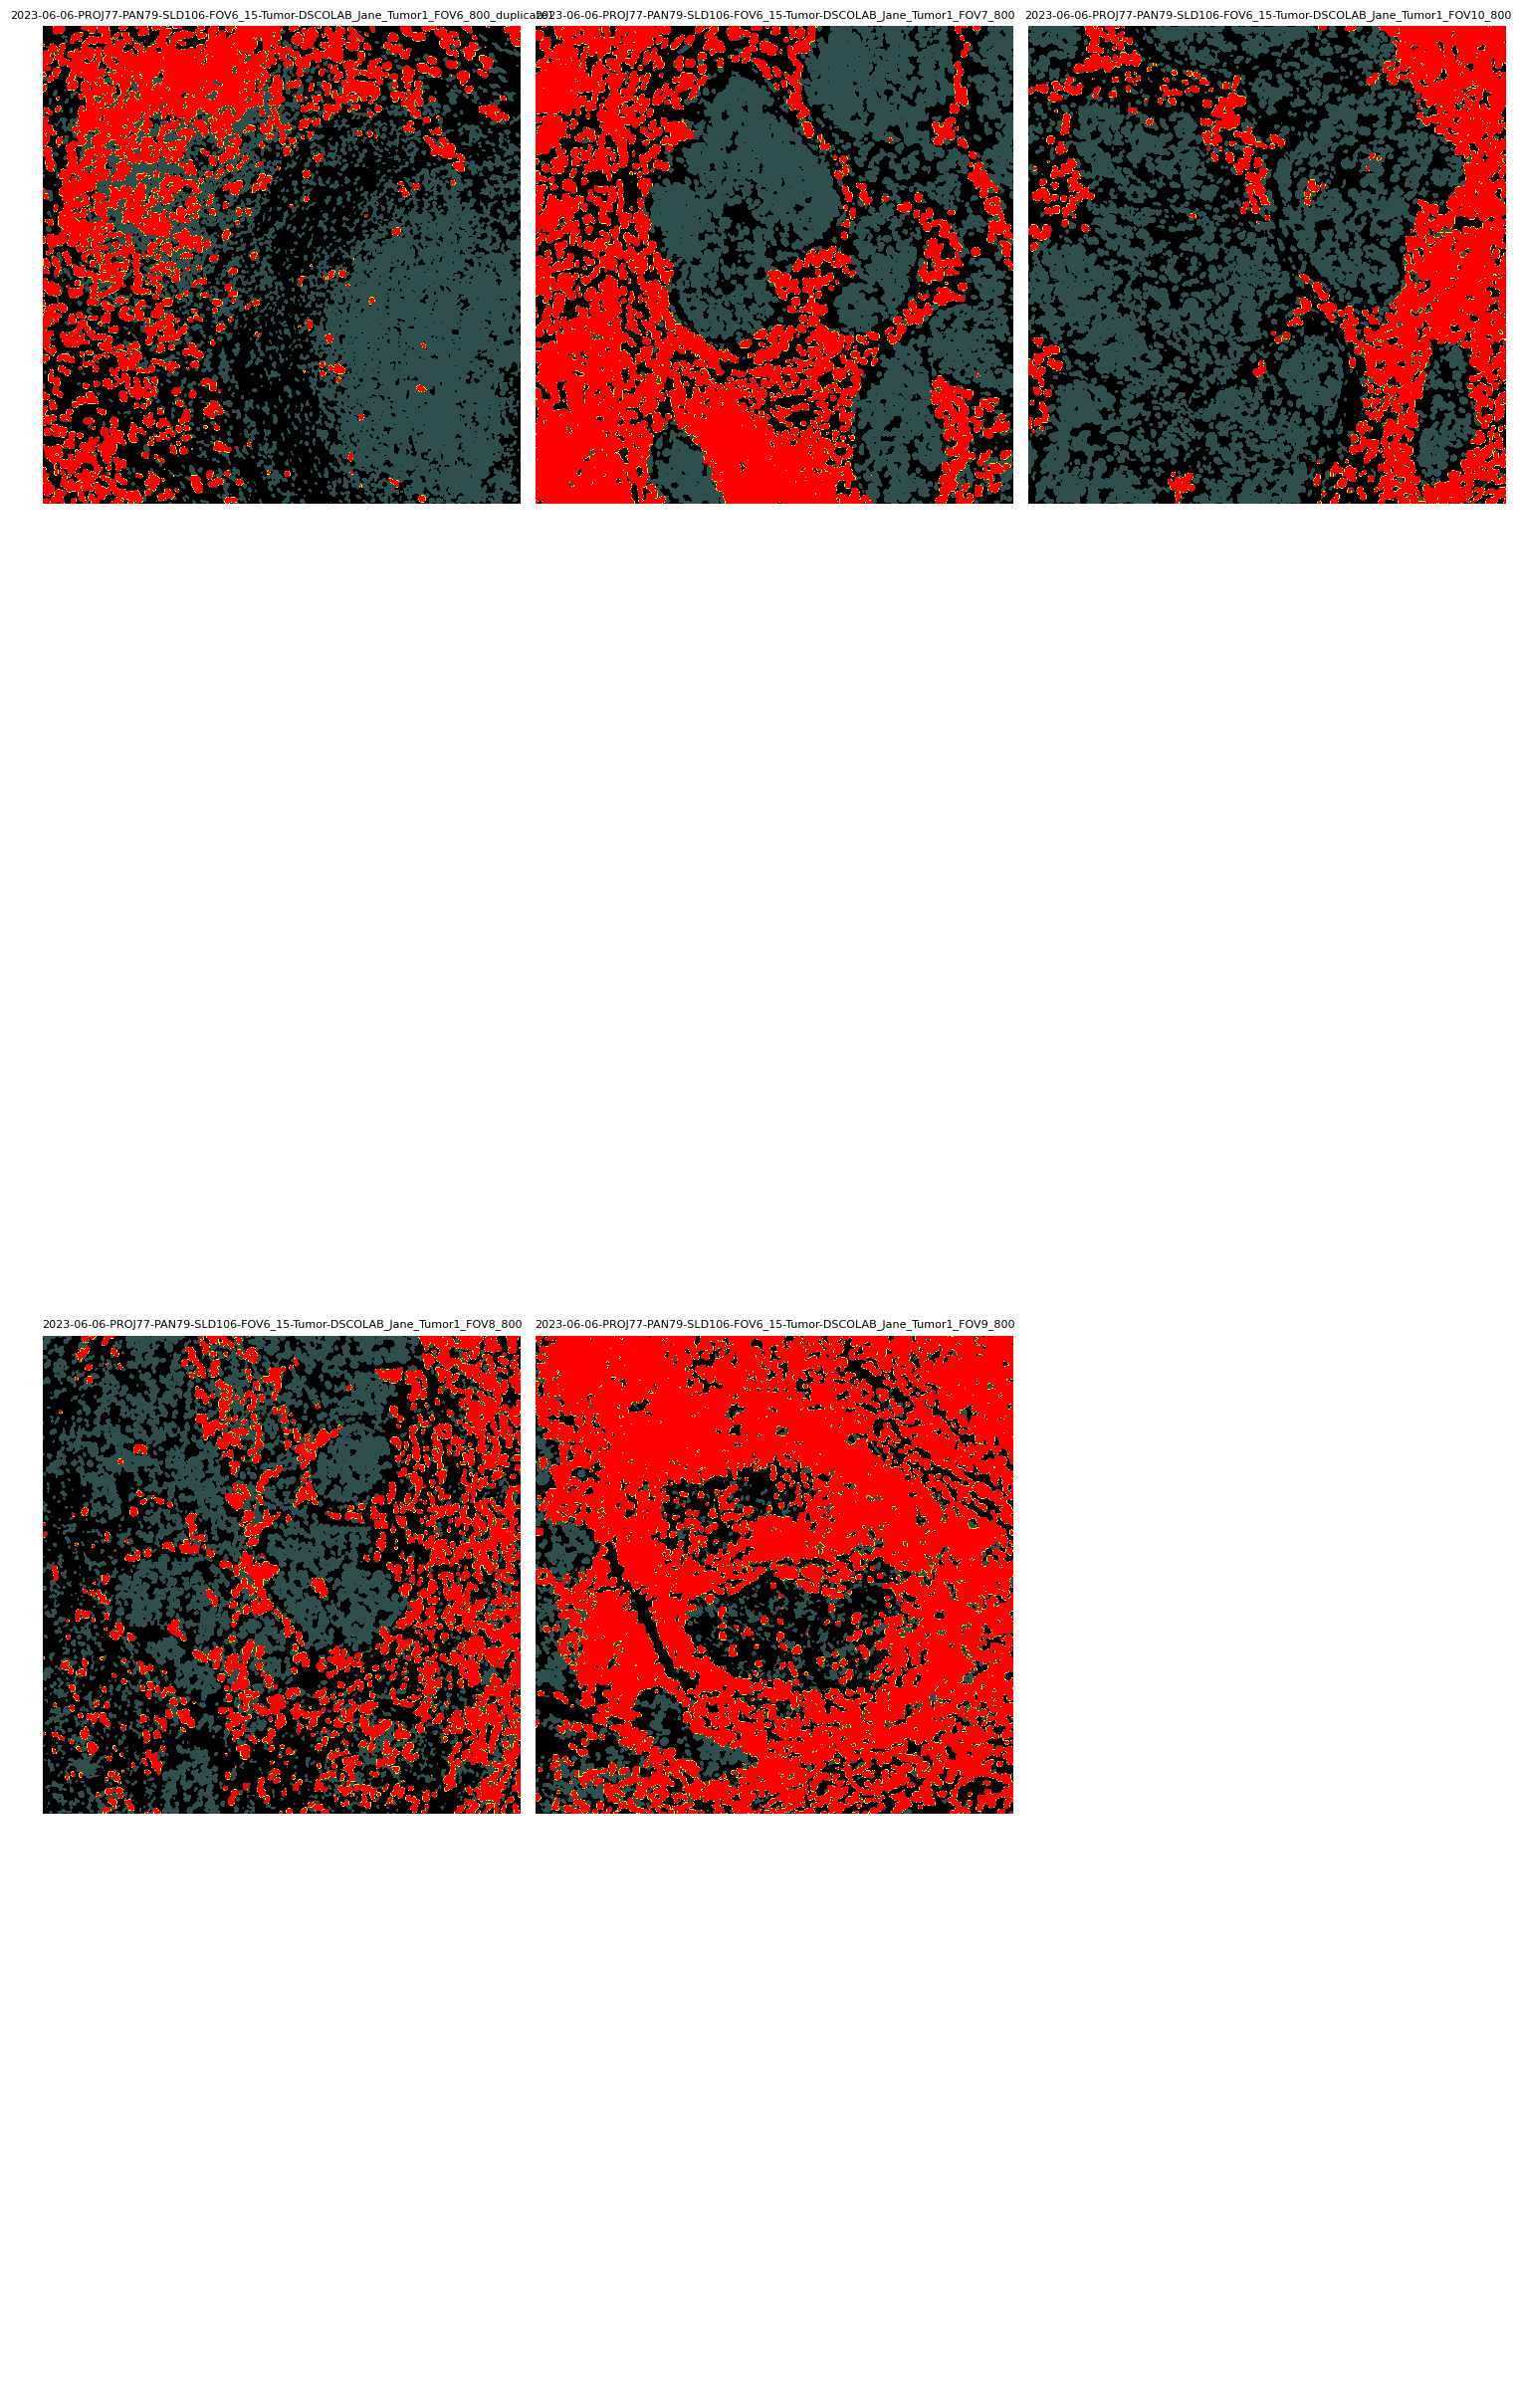

In [8]:
#function to calculate radius from area
def calculate_radius(area):
    radius = math.sqrt(area / math.pi)
    return radius

#Set the number of columns for the subplot grid
num_columns = 3
num_rows = (len(fov_vis) + num_columns - 1) // num_columns
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 30))
#Flatten the axs array if it has multiple dimensions, is this really necessary? idk.
if axs.ndim > 1:
    axs = axs.flatten()

for i, fov in enumerate(fov_vis):
    # Set the correct paths for everything within the for loop so it reads it in the right order.
    nuclear_mask = "_nuclear.tiff"
    cell_mask = "_whole_cell.tiff"
    nuc_seg_path = os.path.join(deepcell_output_dir, fov + nuclear_mask)
    whole_cell_seg_path = os.path.join(deepcell_output_dir, fov + cell_mask)

    # Open up the nuclear mask... doesn't actually do anything yet.
    nuc_seg_mask = np.array(Image.open(nuc_seg_path))

    # Open up the cell mask... what does work.
    whole_cell_seg_mask = np.array(Image.open(whole_cell_seg_path))
    whole_cell_seg_mask2 = np.array(Image.open(whole_cell_seg_path)) # The second one isn't actually modified... it's just used for the visualization.

    # Filter the data frame for the current fov
    filtered_df = df[df['fov'].str.contains(fov)]
    original_numbers = filtered_df['label'].tolist()

    # Filter number 1 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_2 = filtered_df[filtered_df['KRT5'] > 0.2]['label'].astype(int).tolist()
    numbers_to_expand_2 = filtered_df[~(filtered_df['KRT5'] > 0.2)]['label'].astype(int).tolist()

    # Filter number 2 SET YOUR OWN FITERS HERE!!!!!
    numbers_to_remove_3 = filtered_df[filtered_df['CD90'] < 0.18]['label'].astype(int).tolist()
    numbers_to_expand_3 = filtered_df[~(filtered_df['CD90'] < 0.18)]['label'].astype(int).tolist()

    # Combine the numbers to remove and expand
    combined_numbers_to_remove = list(set(numbers_to_remove_2 + numbers_to_remove_3))
    combined_numbers_to_expand = list(set(numbers_to_expand_2 + numbers_to_expand_3))

    # Create a new numpy array where all the values to remove are taken out so only the values we want are dilated
    mask = np.isin(whole_cell_seg_mask, combined_numbers_to_remove)
    whole_cell_seg_mask[mask] = 0

    # Create an empty array to store the dilated numbers
    dilated_numbers = np.zeros_like(whole_cell_seg_mask)

    # Dilate each cell individually based on its own area
    for number in combined_numbers_to_expand:
        # Find the area for the current number
        area = filtered_df[filtered_df['label'] == number]['area'].iloc[0]

        # Calculate the radius based on the area
        radius = calculate_radius(area)

        # Adjust the dilation size based on the calculated radius
        x_expansion = int(radius * expansion_percent)  # X% increase from radius from above
        y_expansion = int(radius * expansion_percent)  # X% increase from radius from above

        # Create a mask for the current number
        current_number_mask = whole_cell_seg_mask == number

        # Perform dilation on the mask
        dilated_number_mask = grey_dilation(current_number_mask, size=(y_expansion, x_expansion))

        # Update the dilated_numbers array with the dilated mask for the current number
        dilated_numbers = np.where(dilated_number_mask, number, dilated_numbers)

    # Combine the two arrays
    stacked_array = np.stack([dilated_numbers, whole_cell_seg_mask2])
    # Compute the element-wise maximum across the stacked array, ignoring 0 values
    combined_array = np.max(stacked_array, axis=0)
    # Ignore how weird and bogus this is... it's just needed to get things into their proper orientation. Or not... idk.
    combined_array = np.flipud(combined_array)
    combined_array = np.fliplr(combined_array)
    combined_array = np.rot90(combined_array, 2)

    # Save the modified whole cell mask... doesn't do anything for nuc yet.
    image = Image.fromarray(combined_array)
    save_path = os.path.join(expansion_deepcell_output_dir, fov + "_whole_cell.tiff") # this can be changed to reflect what kind of expansion was done.
    image.save(save_path)

    # Visualization using the selected fov to display
    cmap = mcolors.ListedColormap(['black', 'darkslategrey', 'yellow', 'red']) # black = background, grey = untouched, red = original, yellow = new expansion mask
    norm = mcolors.Normalize(vmin=0, vmax=3)
    new_mask = np.zeros_like(combined_array)
    new_mask[np.isin(combined_array, combined_numbers_to_expand)] = 2
    new_mask[np.isin(combined_array, original_numbers)] = 3
    new_mask[np.isin(combined_array, combined_numbers_to_remove)] = 1

    merged_mask = np.maximum(new_mask, new_mask, new_mask)

    axs[i].imshow(merged_mask, cmap=cmap, norm=norm)
    axs[i].axis('off')
    axs[i].set_title(fov, fontsize=8)

# Hide any remaining empty subplots
for j in range(len(fov_vis), num_rows * num_columns):
    axs[j].axis('off')

plt.tight_layout()
#plt.savefig('cell_expansion_multi_fov.png') 
plt.show()

In [17]:
### Optional use this cell to save the cell expansion cell table and load that into the cell removal process.
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=expansion_deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=expansion_deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fov_vis),
    channels=['nuclear_channel', 'membrane_channel']
)

In [18]:
# set to True to add nuclear cell properties to the expression matrix
# have to keep this to false right now as I haven't figured out what to do for the nuclear mask. #just move the nuclear stuff over to the newest folder.
nuclear_counts = False

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = False
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=expansion_deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fov_vis,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(expansion_cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(expansion_cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)

extracting data from 2023-06-06-PROJ77-PAN79-SLD106-FOV6_15-Tumor-DSCOLAB_Jane_Tumor1_FOV10_800
extracting data from 2023-06-06-PROJ77-PAN79-SLD106-FOV6_15-Tumor-DSCOLAB_Jane_Tumor1_FOV6_800_duplicate1
extracting data from 2023-06-06-PROJ77-PAN79-SLD106-FOV6_15-Tumor-DSCOLAB_Jane_Tumor1_FOV7_800
extracting data from 2023-06-06-PROJ77-PAN79-SLD106-FOV6_15-Tumor-DSCOLAB_Jane_Tumor1_FOV8_800
extracting data from 2023-06-06-PROJ77-PAN79-SLD106-FOV6_15-Tumor-DSCOLAB_Jane_Tumor1_FOV9_800


In [21]:
#update the data table so that it loads the cell expansion cell table before cell removal.
expansion_cell_table_dir_update = os.path.join(base_dir, "segmentation_072023_exp/cell_table_expanded/cell_table_arcsinh_transformed.csv")
df = pd.read_csv(expansion_cell_table_dir_update)

## 3. Split large nuclei
Work in progress... come back later.

In [ ]:
# Work in progress... don't run.
#cell_segmentation_labels =
#nuc_segmentation_labels =
#cell_ids =
#min_size =

#segmentation_utils.split_large_nuclei(cell_segmentation_labels = cell_segmentation_labels, nuc_segmentation_labels = nuc_segmentation_labels, cell_ids = cell_ids, min_size = min_size)

## 4. Cell Removal
Finally, use this notebook to take out any cells suspected of being artifact or called due to messy signal.
\
\
Again the results can be visualized at the bottom to ensure the proper cells were removed.

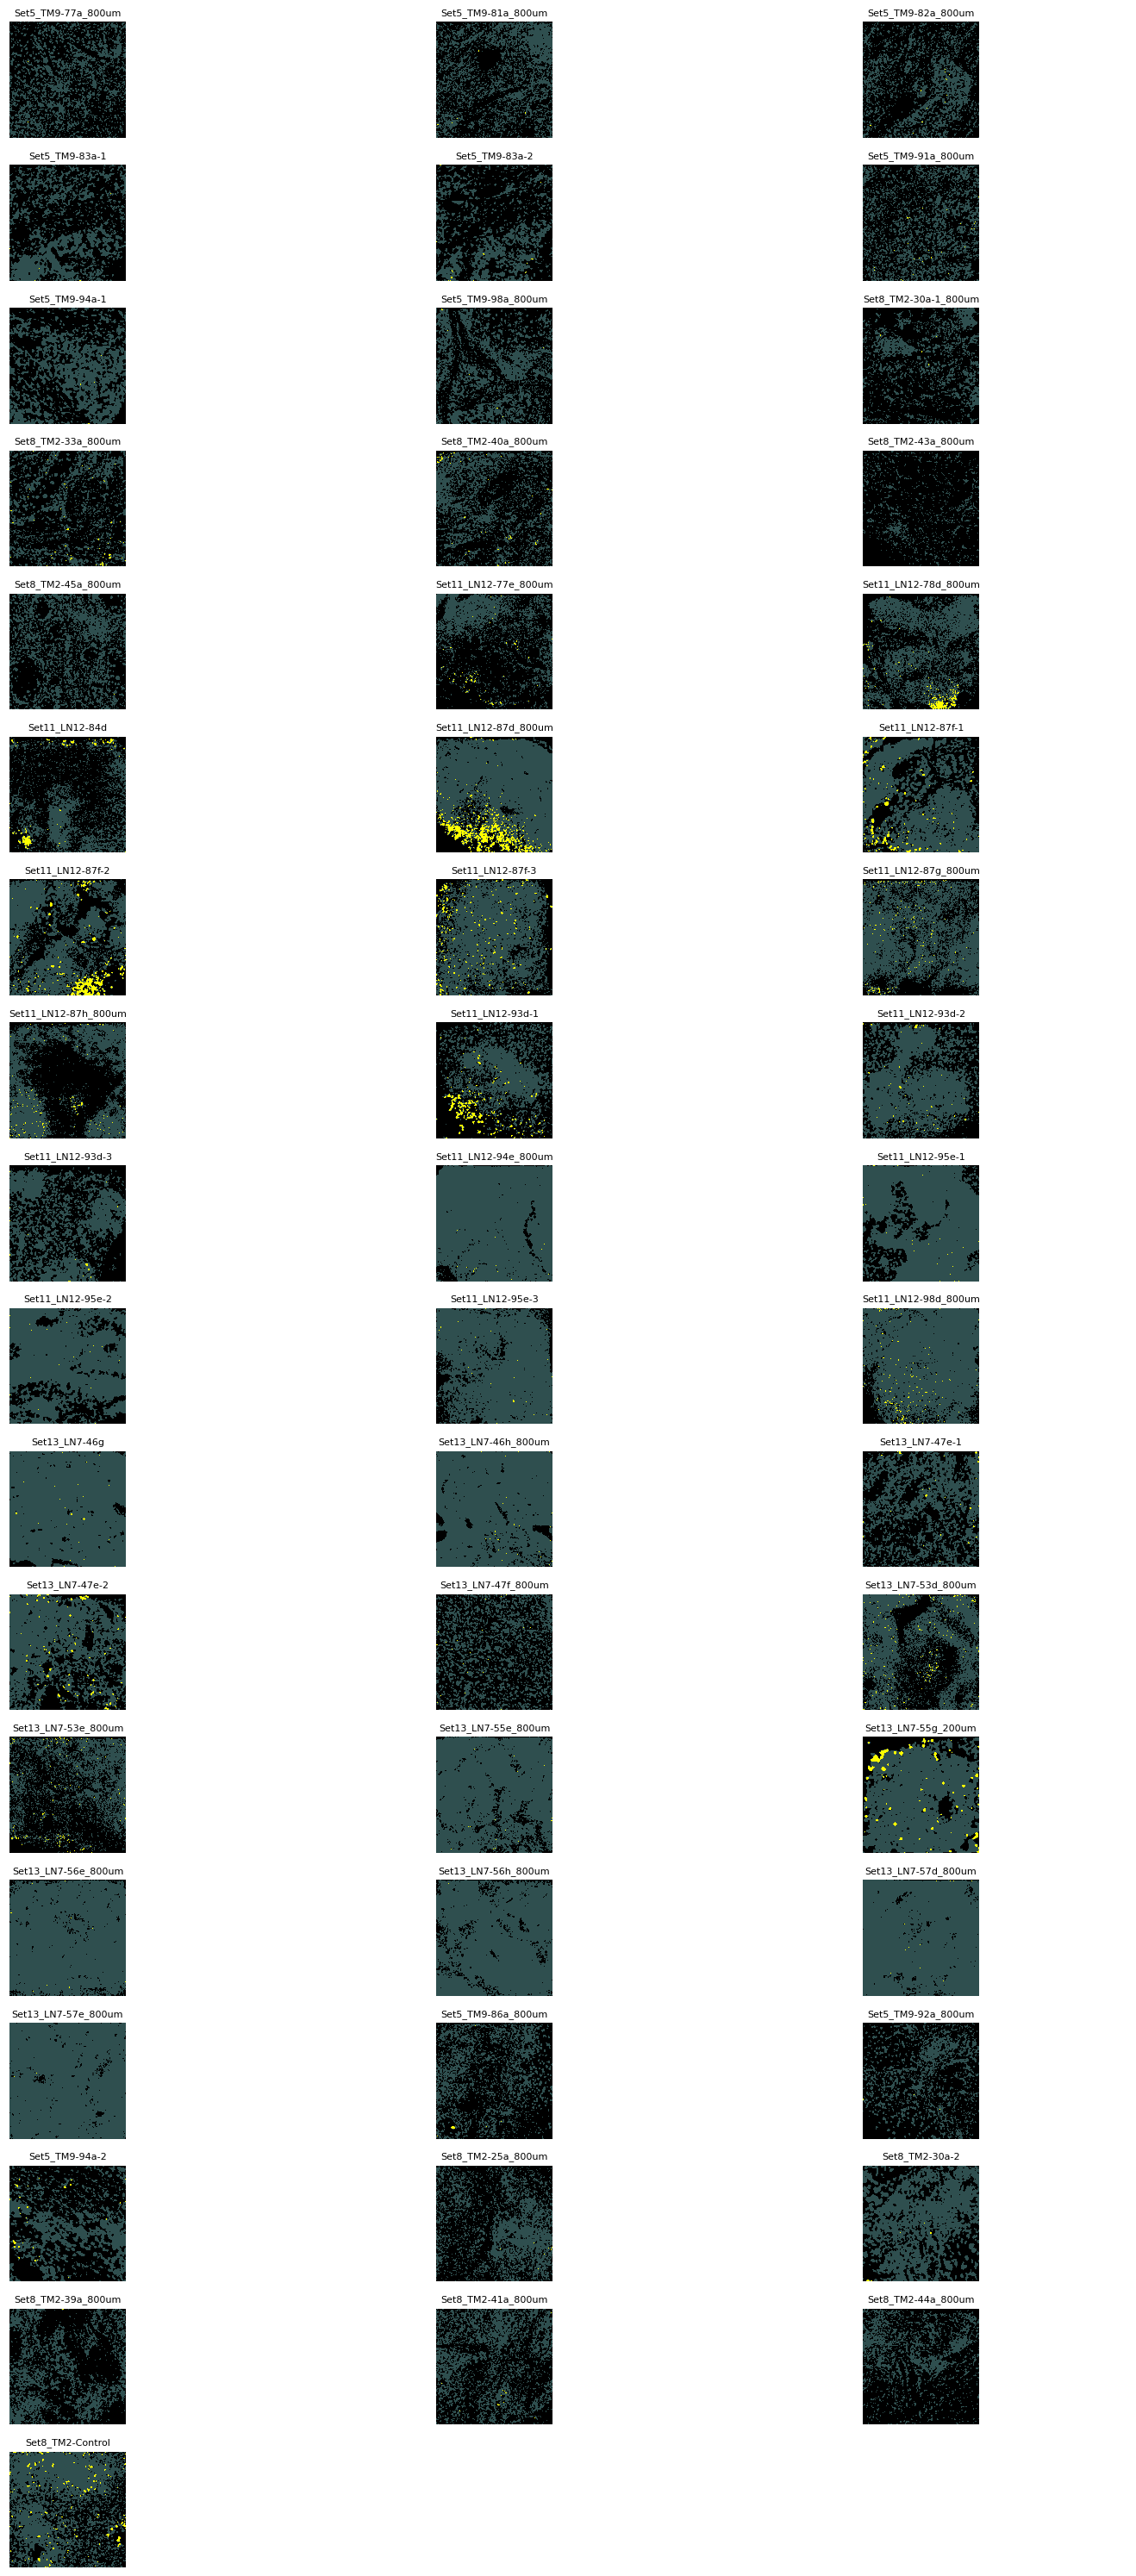

In [13]:
# Set the number of columns for the subplot grid
num_columns = 3
num_rows = (len(fov_vis) + num_columns - 1) // num_columns
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 30))
# Flatten the axs array if it has multiple dimensions
if axs.ndim > 1:
    axs = axs.flatten()

for i, fov in enumerate(fov_vis):
    # Set the correct paths for everything within the for loop so it reads it in the right order.
    nuclear_mask = "_nuclear.tiff"
    cell_mask = "_whole_cell.tiff"
    nuc_seg_path = os.path.join(deepcell_output_dir, fov + nuclear_mask)
    whole_cell_seg_path = os.path.join(deepcell_output_dir, fov + cell_mask)

    # Open up the nuclear mask... doesn't actually do anything yet.
    nuc_seg_mask = np.array(Image.open(nuc_seg_path))

    # Open up the cell mask... what does work.
    whole_cell_seg_mask = np.array(Image.open(whole_cell_seg_path))
    whole_cell_seg_mask2 = np.array(Image.open(whole_cell_seg_path)) #used for visualization

    # Filter the data frame for the current fov
    filtered_df = df[df['fov'].str.contains(fov)]

    # Filter number 1 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_2 = filtered_df[filtered_df['cell_size'] < 50]['label'].astype(int).tolist()
    numbers_to_keep_2 = filtered_df[~(filtered_df['cell_size'] < 50)]['label'].astype(int).tolist()

    # Filter number 2 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_3 = filtered_df[filtered_df['Gold'] > 8]['label'].astype(int).tolist()
    numbers_to_keep_3 = filtered_df[~(filtered_df['Gold'] > 8)]['label'].astype(int).tolist()
    
    # Filter number 2 SET YOUR OWN FILTERS HERE!!!!!
    numbers_to_remove_4 = filtered_df[filtered_df['dsDNA'] < 0.1]['label'].astype(int).tolist()
    numbers_to_keep_4 = filtered_df[~(filtered_df['dsDNA'] < 0.1)]['label'].astype(int).tolist()

    # Make your new function here before adding them to the combined numbers.
    combined_numbers_to_remove = list(set(numbers_to_remove_2 + numbers_to_remove_3 + numbers_to_remove_4))
    combined_numbers_to_keep = list(set(numbers_to_keep_2 + numbers_to_keep_3 + numbers_to_remove_4))

    # Replace all values in the combined list with 0
    mask = np.isin(whole_cell_seg_mask, combined_numbers_to_remove)
    whole_cell_seg_mask[mask] = 0
    
    # Save the modified whole cell mask... doesn't do anything for nuc yet.
    image = Image.fromarray(whole_cell_seg_mask)
    save_path = os.path.join(clean_deepcell_output_dir, fov + "_whole_cell.tiff")
    image.save(save_path)

    # Visualization using the selected fov to display
    cmap = mcolors.ListedColormap(['black', 'darkslategrey', 'yellow']) # black = background, grey = untouched, yellow = cells removed
    norm = mcolors.Normalize(vmin=0, vmax=2)
    new_mask = np.zeros_like(whole_cell_seg_mask2)
    new_mask[np.isin(whole_cell_seg_mask2, combined_numbers_to_keep)] = 1
    new_mask[np.isin(whole_cell_seg_mask2, combined_numbers_to_remove)] = 2
    merged_mask = np.maximum(new_mask, new_mask)

    axs[i].imshow(merged_mask, cmap=cmap, norm=norm)
    axs[i].axis('off')
    axs[i].set_title(fov, fontsize=8)

#Hide any remaining empty subplots
for j in range(len(fov_vis), num_rows * num_columns):
               axs[j].axis('off')

plt.tight_layout()
#plt.savefig('cell_removal.png')
plt.show()

## 5. Create new edited cell table
The last part of this notebook is the same as what is provided by noteboook1: Segmentation.
\
\
If necessary change the name of the cell table to make it easier to identify.

In [15]:
### Optional use this cell to save the cell expansion cell table and load that into the cell removal process.
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=clean_deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=clean_deepcell_visualization_dir,
    fovs=io_utils.remove_file_extensions(fov_vis),
    channels=['nuclear_channel', 'membrane_channel']
)

In [ ]:
# set to True to add nuclear cell properties to the expression matrix
# have to keep this to false right now as I haven't figured out what to do for the nuclear mask.
nuclear_counts = False

# set to True to bypass expensive cell property calculations
# only cell label, size, and centroid will be extracted if True
fast_extraction = True

# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=clean_deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder=None,
                                              fovs=fov_vis,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts,
                                              fast_extraction=fast_extraction)
# Set the compression level if desired, ZSTD compression can offer up to a 60-70% reduction in file size.
# NOTE: Compressed `csv` files cannot be opened in Excel. They must be uncompressed beforehand.
compression = None

# Uncomment the line below to allow for compressed `csv` files.
# compression = {"method": "zstd", "level": 3}

cell_table_size_normalized.to_csv(os.path.join(clean_cell_table_dir, 'cell_table_size_normalized.csv'),
                                  compression=compression, index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(clean_cell_table_dir, 'cell_table_arcsinh_transformed.csv'),
                                      compression=compression, index=False)

extracting data from Set11_LN12-77e_800um
extracting data from Set11_LN12-78d_800um
extracting data from Set11_LN12-84d
extracting data from Set11_LN12-87d_800um
extracting data from Set11_LN12-87f-1
extracting data from Set11_LN12-87f-2
extracting data from Set11_LN12-87f-3
extracting data from Set11_LN12-87g_800um
extracting data from Set11_LN12-87h_800um
extracting data from Set11_LN12-93d-1
extracting data from Set11_LN12-93d-2
extracting data from Set11_LN12-93d-3
extracting data from Set11_LN12-94e_800um
extracting data from Set11_LN12-95e-1
extracting data from Set11_LN12-95e-2
extracting data from Set11_LN12-95e-3
extracting data from Set11_LN12-98d_800um
extracting data from Set13_LN7-46g
extracting data from Set13_LN7-46h_800um
extracting data from Set13_LN7-47e-1
extracting data from Set13_LN7-47e-2
extracting data from Set13_LN7-47f_800um
extracting data from Set13_LN7-53d_800um
extracting data from Set13_LN7-53e_800um
extracting data from Set13_LN7-55e_800um
extracting dat